# Лабораторная работа: Случайный лес (классификация)

В этой работе выполняются:

- Подготовка данных: очистка, обработка пропусков, кодирование категориальных признаков, при необходимости масштабирование
- Обучение базовой модели `RandomForestClassifier`
- Оценка качества модели: accuracy, precision, recall, F1-score, матрица ошибок
- Настройка гиперпараметров с помощью `GridSearchCV`
- Повторная оценка с подобранными параметрами
- Интерпретация важности признаков и визуализация

Датасет: используем `breast_cancer` из `scikit-learn`. Для демонстрации предобработки добавим синтетический категориальный признак и искусственные пропуски.


In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier



{'python': '3.13.3', 'numpy': '2.3.5', 'pandas': '2.3.3', 'seaborn': '0.13.2', 'matplotlib': '3.10.7', 'sklearn': '1.7.2'}


## Подготовка и первичный анализ данных

Загрузим датасет `breast_cancer`, сформируем `DataFrame`, посмотрим размерность, типы, описательные статистики и распределение целевого класса.


shape: (569, 30)
types:
 mean radius        float64
mean texture       float64
mean perimeter     float64
mean area          float64
mean smoothness    float64
dtype: object

class balance:
target
benign       0.627417
malignant    0.372583
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.8000,39.2800
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.1000,188.5000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.7000,2501.0000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634


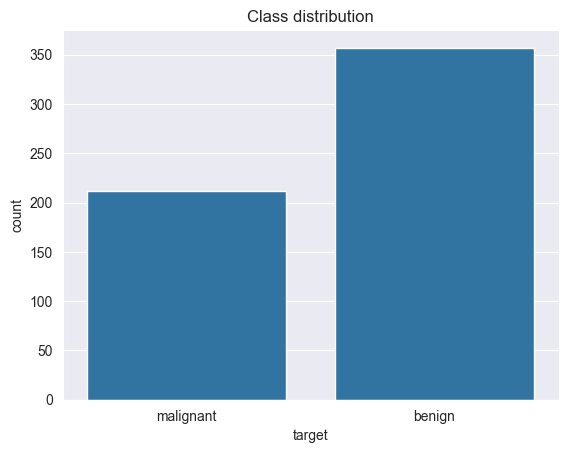

In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print('shape:', X.shape)
print('types:\n', X.dtypes.head())
print('\nclass balance:')
print(y.value_counts(normalize=True).rename({0: 'malignant', 1: 'benign'}))

display(X.describe().T.head())

sns.countplot(x=y.map({0: 'malignant', 1: 'benign'}))
plt.title('Class distribution')
plt.show()


## Синтетические пропуски и категориальный признак

Для демонстрации предобработки добавим:
- категориальный признак `texture_group` на основе `mean texture` (квантильная бининга)
- случайные пропуски в нескольких числовых столбцах


In [3]:
rng = np.random.default_rng(42)
X_ext = X.copy()

tex = pd.qcut(X_ext['mean texture'], q=3, labels=['low', 'mid', 'high'])
X_ext['texture_group'] = tex.astype('category')

num_cols = X_ext.drop(columns=['texture_group']).columns
for col in rng.choice(num_cols, size=3, replace=False):
    idx = rng.choice(X_ext.index, size=15, replace=False)
    X_ext.loc[idx, col] = np.nan

print('added categorical column:', 'texture_group' in X_ext.columns)
print('missing values per column (non-zero shown):')
missing = X_ext.isna().sum()
print(missing[missing > 0].sort_values(ascending=False))


added categorical column: True
missing values per column (non-zero shown):
mean perimeter             15
fractal dimension error    15
worst perimeter            15
dtype: int64


## Разделение данных и базовая модель

- Разобьём данные на train/test
- Настроим `ColumnTransformer` для числовых и категориальных признаков
- Соберём конвейер с `RandomForestClassifier`


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ext, y, test_size=0.2, random_state=42, stratify=y
)

categorical_cols = ['texture_group']
numeric_cols = [c for c in X_ext.columns if c not in categorical_cols]

numeric_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_prep, numeric_cols),
        ('cat', categorical_prep, categorical_cols),
    ]
)

baseline_model = Pipeline(steps=[
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42))
])

baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
print('Baseline accuracy:', accuracy_score(y_test, y_pred))


Baseline accuracy: 0.9473684210526315


## Оценка базовой модели

Рассчитаем accuracy, precision, recall, F1-score и построим матрицу ошибок.


{'accuracy': 0.9473684210526315, 'precision': 0.9583333333333334, 'recall': 0.9583333333333334, 'f1': 0.9583333333333334}

classification report:

              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        42
      benign       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



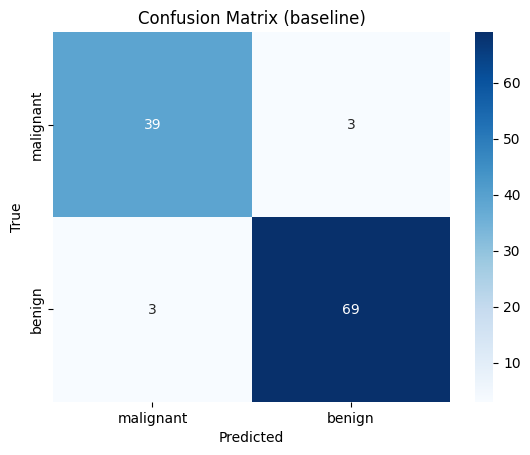

In [5]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
print('\nclassification report:\n')
print(classification_report(y_test, y_pred, target_names=['malignant', 'benign']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['malignant','benign'], yticklabels=['malignant','benign'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (baseline)')
plt.show()


## Подбор гиперпараметров (GridSearchCV)

Ищем оптимальные значения числа деревьев, глубины, максимальных признаков и минимального числа образцов в листе.


In [6]:
param_grid = {
    'rf__n_estimators': [100, 300, 600],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print('best params:', grid.best_params_)
print('best cv score (f1):', grid.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
best params: {'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 600}
best cv score (f1): 0.968571219746438


## Оценка модели с подобранными параметрами

Сравним метрики и матрицу ошибок на тестовой выборке.


{'accuracy': 0.956140350877193, 'precision': 0.958904109589041, 'recall': 0.9722222222222222, 'f1': 0.9655172413793104}

classification report (best):

              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



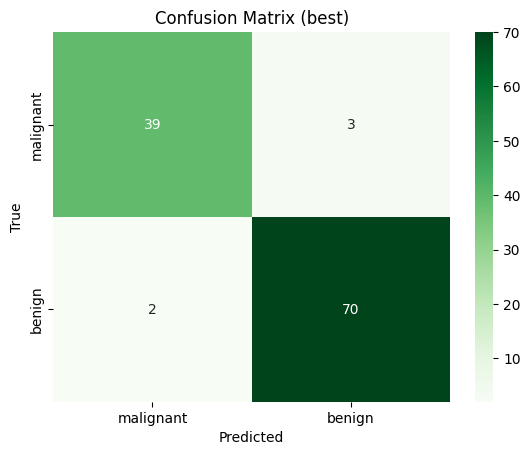

In [7]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

acc_b = accuracy_score(y_test, y_pred_best)
prec_b = precision_score(y_test, y_pred_best)
rec_b = recall_score(y_test, y_pred_best)
f1_b = f1_score(y_test, y_pred_best)

print({'accuracy': acc_b, 'precision': prec_b, 'recall': rec_b, 'f1': f1_b})
print('\nclassification report (best):\n')
print(classification_report(y_test, y_pred_best, target_names=['malignant', 'benign']))

cm_b = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens', xticklabels=['malignant','benign'], yticklabels=['malignant','benign'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (best)')
plt.show()


## Важность признаков

Извлечём имена признаков после преобразований и покажем важности из случайного леса.


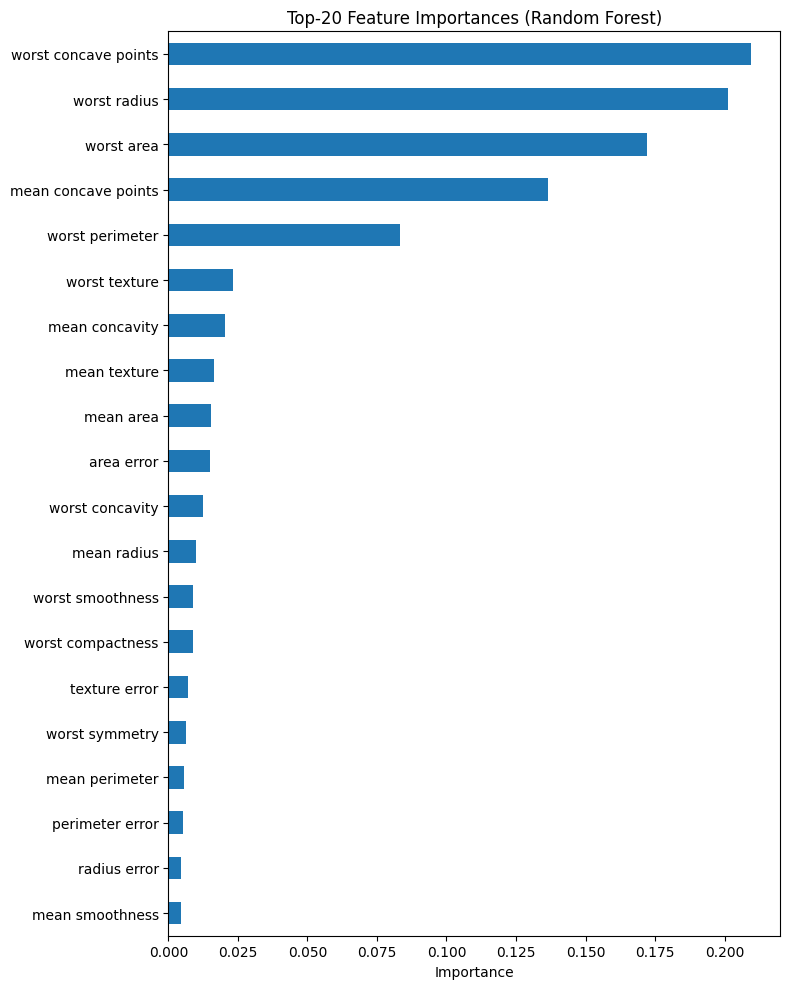

Top 10 features:
worst concave points    0.209453
worst radius            0.201311
worst area              0.172108
mean concave points     0.136486
worst perimeter         0.083395
worst texture           0.023135
mean concavity          0.020239
mean texture            0.016515
mean area               0.015233
area error              0.014952
dtype: float64


In [8]:
def get_feature_names(preprocessor, numeric_cols, categorical_cols):
    num_features = numeric_cols
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_features = list(cat_encoder.get_feature_names_out(categorical_cols))
    return list(num_features) + cat_features

feature_names = get_feature_names(best_model.named_steps['prep'], numeric_cols, categorical_cols)
importances = best_model.named_steps['rf'].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
fi.head(20).iloc[::-1].plot(kind='barh')
plt.title('Top-20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print('Top 10 features:')
print(fi.head(10))
